## Unsupervised Learning Analysis: Cluster Interpretation

This section details the validation and interpretation of the **K-Means Clustering model**. By combining dimensionality reduction (PCA) with feature profiling, we will decode the "DNA" of the user's listening habits.

For this analysis, we'll focus on the 'sound' and numeric features and determine an adecute number of 'group' (clusters) to classify the user's tastes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../backend/data/clean_tracks_for_clustering.csv')
print(f"Imported data: {df.shape}")

Imported data: (28350, 24)


In [3]:
# We use only the "sound" and numeric features
cluster_features = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo'
]

X = df[cluster_features].copy()

# Z-Score Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data, ready for clustering.")

Scaled data, ready for clustering.


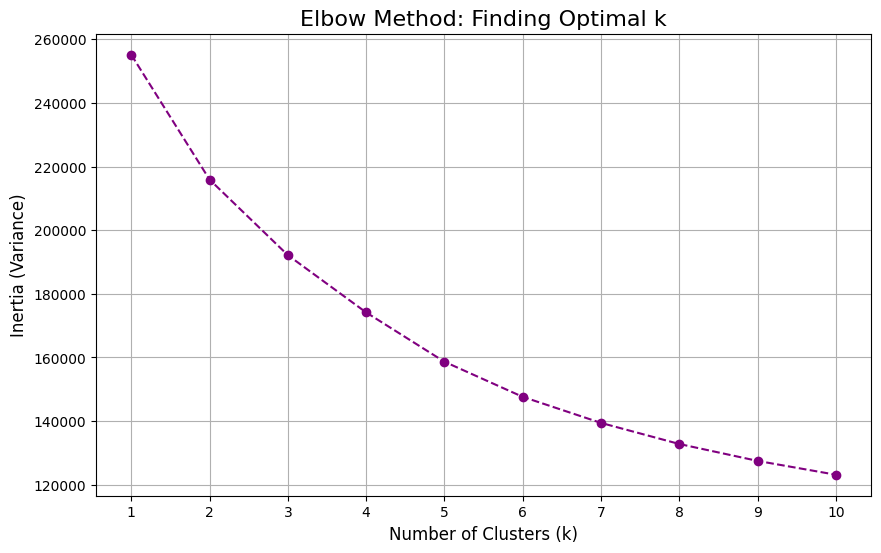

In [4]:
# Determine the inertion (Within-cluster sum of squares) from k=1 to k=10
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot to check the 'elbow'
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='purple')
plt.title('Elbow Method: Finding Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Variance)', fontsize=12)
plt.xticks(K_range)
plt.grid(True)
plt.show()

Visually, it seems that 4 to 6 would be an adecuate number of clusters. Let's take a deeper look. We'll use two metrics to gain more insights: **Silhouette Score** and **Davies-Boulding Index**.

In [6]:
k_values = [4, 5, 6]
results = []

print('Calculating metrics, it might take a while...')

for k in k_values:
    # Train the model
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_scaled)
    
    # Calculate metrics
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    
    results.append({
        'k': k,
        'Silhouette (Higher is better)': sil_score,
        'Davies-Bouldin (Lower is better)': db_score
    })

metrics_df = pd.DataFrame(results).set_index('k')
print("\n--- Comparison (4 to 6 clusters) ---")
display(metrics_df)

Calculating metrics, it might take a while...



--- Comparison (4 to 6 clusters) ---


,Silhouette (Higher is better),Davies-Bouldin (Lower is better)
k,,
4,0.153062,1.830974
5,0.155601,1.696655
6,0.158923,1.593358


### Model Selection: Determining the optimal number of clusters

We proceed with `k = 5` clusters. Quantitative evaluation using the **Davies-Bouldin Index (DBI)** and **Silhouette Score** reveals that `k = 5` offers the optimal balance between mathematical cohesion and business interpretability.

1. **Rejection of `k = 4`:** The model showed poor separation (DBI: 1.83), indicating that four categories were insufficient to capture the variance in musical styles, forcing distinct subgroups into merged clusters.
2. **`k = 5` as the Sweet spot:** Increasing to five clusters yielded a significant improvement in separation (DBI dropped to 1.69). This represents a distinct gain in cluster definition.
3. **Rejection of `k = 6`:** While `k = 6` offered a marginal metric improvement (DBI: 1.59), we prioritize **Model Parsimony**. The slight mathematical gain does not justify the added cognitive load for the end-user. Five profiles align better with standard psychological archetypes (e.g., Big Five) for effective storytelling.

---

In [7]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['mood_cluster'] = kmeans.fit_predict(X_scaled)

print(f"Clusterization completed ({optimal_k} groups).")

Clusterization completed (5 groups).


### Dimensionality Analysis: PCA Axis Meaning

**Context:** Principal Component Analysis (PCA) compresses the 9 audio features into 2 distinct "Super-Variables" (PC1 and PC2) to allow for 2D visualization. Understanding how each feature contributes to each principal components helps us to translate 'where the point it's in the map' to 'what the user it's feeling'.  

**Interpretation:**

* **Principal Component 1 (X-Axis)  The "Intensity Spectrum" (Organic vs. Synthetic)**
    * *Drivers:* Strong positive correlation with **Energy (+0.61)** and **Loudness (+0.55)**; strong negative correlation with **Acousticness (-0.49)**.
    * *Meaning:* Moving from Left to Right, the music shifts from "Soft/Acoustic/Unplugged" to "Loud/Produced/Electronic".


* **Principal Component 2 (Y-Axis)  The "Mood Spectrum" (Introspective vs. Social)**
    * *Drivers:* Strong positive correlation with **Danceability (+0.62)** and **Valence (+0.57)**.
    * *Meaning:* Moving from Bottom to Top, the music shifts from "Serious/Instrumental" to "Happy/Danceable/Party".

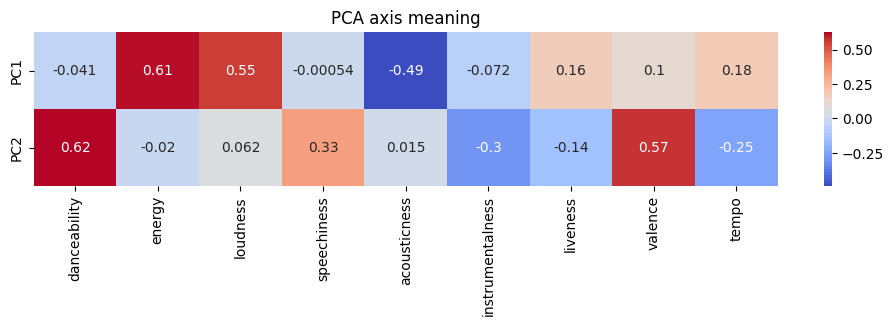

In [8]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Add coordinates to the dataframe
df['pca_1'] = principal_components[:, 0]
df['pca_2'] = principal_components[:, 1]

pca_components = pd.DataFrame(
    pca.components_, 
    columns=cluster_features, 
    index=['PC1', 'PC2']
)

# Plot a heatmap to check which features are more dominant
plt.figure(figsize=(12, 2))
sns.heatmap(pca_components, cmap='coolwarm', annot=True)
plt.title('PCA axis meaning')
plt.show()


### Spatial Distribution: K-Means Clustering Visualization

A scatterplot projecting the 30,000+ tracks onto the interpreted PCA axes, colored by their assigned Cluster ID.

**Interpretation:**

* **Cluster Separation:** The model shows clear spatial segregation, validating the decision to use `k = 5`. The lack of significant overlap between the "Organic" zone (left) and the "High Intensity" zone (right) proves that the algorithm has successfully distinguished fundamental musical structures.
* **The "V" Shape:** The data naturally forms a "V" or fan shape opening towards the right. This indicates that as music becomes more intense (moving right), it branches into two distinct directions: "Happy/Dance" (Top-Right) and "Aggressive/Serious" (Bottom-Right).

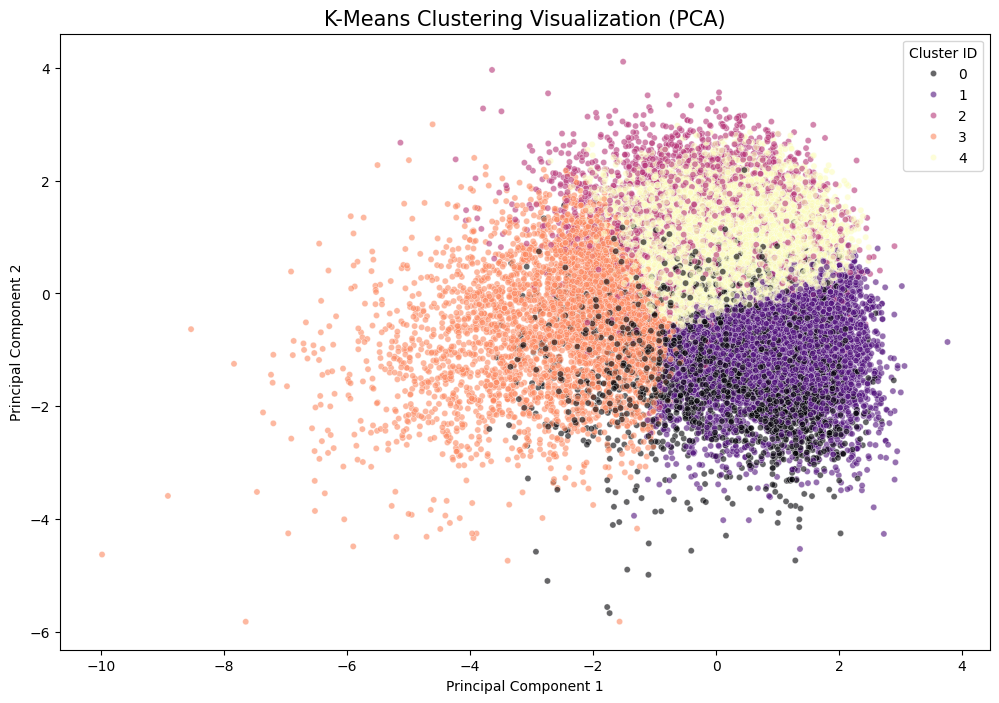

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, 
    x='pca_1', 
    y='pca_2', 
    hue='mood_cluster', 
    palette='magma', 
    alpha=0.6,
    s=20
)
plt.title('K-Means Clustering Visualization (PCA)', fontsize=15)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster ID')
plt.show()

### Cluster Characterization: Audio Feature Heatmap

**Context:** A matrix displaying the average value of each audio feature for each cluster. **Note:** Values are displayed in their original units (BPM, Decibels, 0-1 Scale) for business interpretability.

**Key Findings by Cluster:**

* **Cluster 0:** Characterized by high Energy (0.78) and a standardized Tempo (~125 BPM).
* **Cluster 1:** The most extreme cluster. Highest Energy (0.80) and Highest Tempo (132 BPM), but low Acousticness.
* **Cluster 2:** A balanced profile with high Danceability (0.72) and moderate Energy.
* **Cluster 3:** The outlier. Highest Acousticness (0.52) and Lowest Energy (0.43).
* **Cluster 4:** The emotional peak. Highest Valence (0.67) and Highest Danceability (0.74).

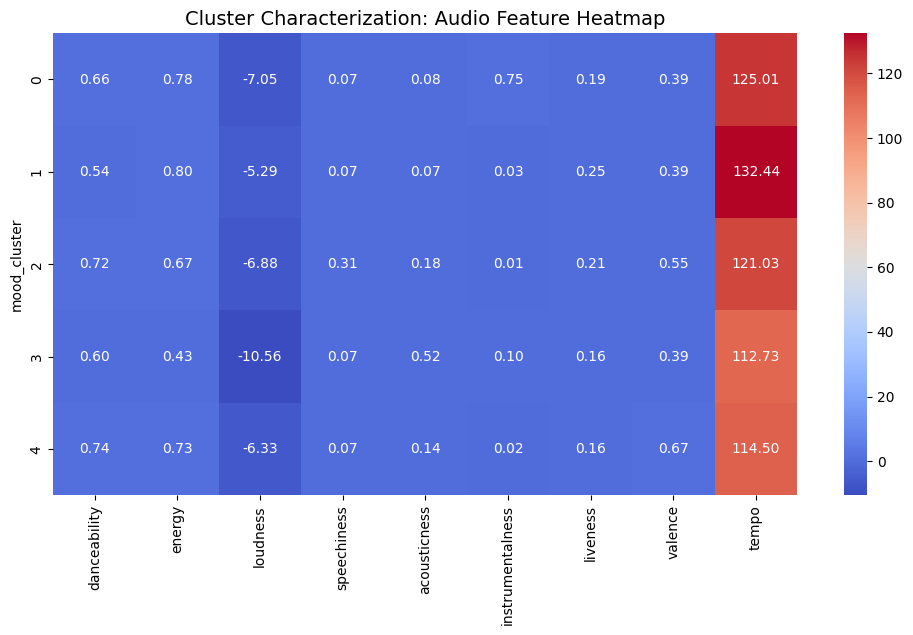

In [10]:
# Calculate the mean of each feature per cluster
cluster_summary = df.groupby('mood_cluster')[cluster_features].mean().reset_index()

# Plot as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_summary.set_index('mood_cluster'), 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f"
)
plt.title('Cluster Characterization: Audio Feature Heatmap', fontsize=14)
plt.show()

## Final Psychological Profiles (Backend Definitions)

Based on the data above, the following definitions are established for the **Psychological Profile Engine**. These rules will be used to tag users based on their dominant cluster.

| Cluster ID | Profile Name | Archetype Definition (Business Logic) | Key Trigger Features |
| --- | --- | --- | --- |
| **Cluster 3** | **The Organic / Relaxed** | User seeks calmness, disconnection, or focus. Prefers natural sounds over synthesized production. Likely engages in "Deep Work" or relaxation. | `High Acousticness`, `Low Energy` |
| **Cluster 4** | **The Euphoric / Social** | User seeks dopamine and social connection. Prefers music that is explicitly happy and danceable. Indicative of "Party" or "Mood-Lifting" sessions. | `Max Valence`, `Max Danceability` |
| **Cluster 1** | **The High Intensity** | User seeks adrenaline and power. Prefers fast, aggressive, or heavy music (Metal, Hard Techno, Gym). Focus is on physical stimulation, not necessarily happiness. | `Max Tempo (>130 BPM)`, `Max Energy` |
| **Cluster 0** | **The Rhythmic Flow** | User seeks momentum and consistency. Prefers the steady 120-128 BPM range (House, Modern Pop) that maintains a "Flow State" without emotional extremes. | `Fixed Tempo (~125 BPM)`, `High Energy` |
| **Cluster 2** | **The Mainstream Groove** | User seeks accessibility and balance. Prefers polished, radio-friendly structures with a good groove. Represents the versatile "middle ground" listener. | `High Danceability`, `Mid-High Energy` |